In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym

## GridWorld Environment
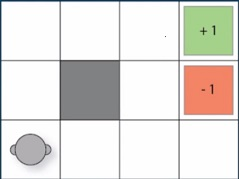

In [2]:
class Grid: # Environment
  def __init__(self, width, height, start):
    self.width = width
    self.height = height
    self.i = start[0]
    self.j = start[1]

  def set(self, rewards, actions):
    # rewards should be a dict of: (i, j): r (row, col): reward
    # actions should be a dict of: (i, j): A (row, col): list of possible actions
    self.rewards = rewards
    self.actions = actions

  def set_state(self, s):
    self.i = s[0]
    self.j = s[1]

  def current_state(self):
    return (self.i, self.j)

  def is_terminal(self, s):
    return s not in self.actions

  def move(self, action):
    # check if legal move first
    if action in self.actions[(self.i, self.j)]:
      if action == 'U':
        self.i -= 1
      elif action == 'D':
        self.i += 1
      elif action == 'R':
        self.j += 1
      elif action == 'L':
        self.j -= 1
    # return a reward (if any)
    return self.rewards.get((self.i, self.j), 0)

  def undo_move(self, action):
    # these are the opposite of what U/D/L/R should normally do
    if action == 'U':
      self.i += 1
    elif action == 'D':
      self.i -= 1
    elif action == 'R':
      self.j -= 1
    elif action == 'L':
      self.j += 1
    # raise an exception if we arrive somewhere we shouldn't be
    # should never happen
    assert(self.current_state() in self.all_states())

  def game_over(self):
    # returns true if game is over, else false
    # true if we are in a state where no actions are possible
    return (self.i, self.j) not in self.actions

  def all_states(self):
    # possibly buggy but simple way to get all states
    # either a position that has possible next actions
    # or a position that yields a reward
    return set(self.actions.keys()) | set(self.rewards.keys())


def standard_grid():
  # define a grid that describes the reward for arriving at each state
  # and possible actions at each state
  # the grid looks like this
  # x means you can't go there
  # s means start position
  # number means reward at that state
  # .  .  .  1
  # .  x  . -1
  # s  .  .  .
  g = Grid(3, 4, (2, 0))
  rewards = {(0, 3): 1, (1, 3): -1}
  actions = {
    (0, 0): ('D', 'R'),
    (0, 1): ('L', 'R'),
    (0, 2): ('L', 'D', 'R'),
    (1, 0): ('U', 'D'),
    (1, 2): ('U', 'D', 'R'),
    (2, 0): ('U', 'R'),
    (2, 1): ('L', 'R'),
    (2, 2): ('L', 'R', 'U'),
    (2, 3): ('L', 'U'),
  }
  g.set(rewards, actions)
  return g


def negative_grid(step_cost=-0.1):
  # in this game we want to try to minimize the number of moves
  # so we will penalize every move
  g = standard_grid()
  g.rewards.update({
    (0, 0): step_cost,
    (0, 1): step_cost,
    (0, 2): step_cost,
    (1, 0): step_cost,
    (1, 2): step_cost,
    (2, 0): step_cost,
    (2, 1): step_cost,
    (2, 2): step_cost,
    (2, 3): step_cost,
  })
  return g


def print_values(V, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      v = V.get((i,j), 0)
      if v >= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="") # -ve sign takes up an extra space
    print("")


def print_policy(P, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      a = P.get((i,j), ' ')
      print("  %s  |" % a, end="")
    print("")

## Model-Free RL

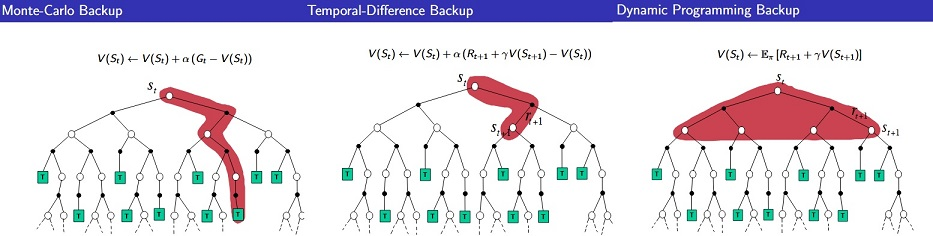

## MC Control problem

## Calculating returns

In [3]:
def random_action(a, eps=0.1):
  # choose given a with probability 1 - eps + eps/4
  p = np.random.random()
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [4]:
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

In [5]:
def play_game(grid, policy):
  # returns a list of states and corresponding returns
  # use an epsilon-soft policy
  s = (2, 0)
  grid.set_state(s)
  a = random_action(policy[s])

  # each triple is s(t), a(t), r(t)
  # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
  states_actions_rewards = [(s, a, 0)]
  while True:
    r = grid.move(a)
    s = grid.current_state()
    if grid.game_over():
      states_actions_rewards.append((s, None, r))
      break
    else:
      a = random_action(policy[s]) # the next state is stochastic
      states_actions_rewards.append((s, a, r))

  # calculate the returns by working backwards from the terminal state
  G = 0
  states_actions_returns = []
  first = True
  for s, a, r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_actions_returns.append((s, a, G))
    G = r + GAMMA*G
  states_actions_returns.reverse() # we want it to be in order of state visited
  return states_actions_returns

In [6]:
# convergence condition
SMALL_ENOUGH = 1e-3
# learning rate
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
# this grid gives you a reward of -0.1
# to find a shorter path to the goal, use negative grid
grid = negative_grid(step_cost=-0.9)
# print rewards
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.90|-0.90|-0.90| 1.00|
---------------------------
-0.90| 0.00|-0.90|-1.00|
---------------------------
-0.90|-0.90|-0.90|-0.90|


In [7]:
# state -> action
# initialize a random policy
policy = {}
for s in grid.actions.keys():
  policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)
  
# initial policy
print("initial policy:")
print_policy(policy, grid)

initial policy:
---------------------------
  D  |  U  |  U  |     |
---------------------------
  U  |     |  D  |     |
---------------------------
  R  |  R  |  U  |  U  |


In [8]:
# initialize Q(s,a) and returns
Q = {}
returns = {} # dictionary of state -> list of returns we've received
states = grid.all_states()
for s in states:
  if s in grid.actions: # not a terminal state
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      Q[s][a] = 0
      returns[(s,a)] = []
  else:
    # terminal state or state we can't otherwise get to
    pass
  
# initial Q values for all states in grid
print(Q)

{(0, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (0, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (0, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}}


In [9]:
# repeat
deltas = []
for t in range(5000):
  # generate an episode using pi
  biggest_change = 0
  states_actions_returns = play_game(grid, policy)

  # calculate Q(s,a)
  seen_state_action_pairs = set()
  for s, a, G in states_actions_returns:
    # check if we have already seen s
    # called "first-visit" MC policy evaluation
    sa = (s, a)
    if sa not in seen_state_action_pairs:
      old_q = Q[s][a]
      returns[sa].append(G)
      Q[s][a] = np.mean(returns[sa])
      biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
      seen_state_action_pairs.add(sa)
  deltas.append(biggest_change)

  # calculate new policy pi(s) = argmax[a]{ Q(s,a) }
  for s in policy.keys():
    a, _ = max_dict(Q[s])
    policy[s] = a

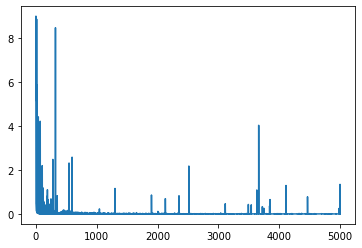

In [10]:
plt.plot(deltas)
plt.show()

In [11]:
# find the optimal state-value function
# V(s) = max[a]{ Q(s,a) }
V = {}
for s in policy.keys():
  V[s] = max_dict(Q[s])[1]

print("final values:")
print_values(V, grid)

final values:
---------------------------
-1.71|-0.20| 1.00| 0.00|
---------------------------
-3.41| 0.00|-0.12| 0.00|
---------------------------
-2.73|-1.96|-1.10|-1.00|


In [12]:
print("final policy:")
print_policy(policy, grid)

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  D  |     |  U  |     |
---------------------------
  R  |  R  |  U  |  U  |


## Temporal Difference

## SARSA (TD control problem, On-Policy)

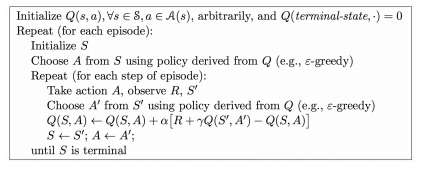

In [13]:
SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
ALPHA = 0.1

In [14]:
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

In [15]:
def random_action(a, eps=0.1):
  # epsilon-soft to ensure all states are visited
  p = np.random.random()
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [16]:
grid = negative_grid(step_cost=-0.9)

# print rewards
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.90|-0.90|-0.90| 1.00|
---------------------------
-0.90| 0.00|-0.90|-1.00|
---------------------------
-0.90|-0.90|-0.90|-0.90|


In [17]:
# no policy initialization,  policy is derived from most recent Q

# initialize Q(s,a)
Q = {}
states = grid.all_states()
for s in states:
  Q[s] = {}
  for a in ALL_POSSIBLE_ACTIONS:
    Q[s][a] = 0
      
# initial Q values for all states in grid
print(Q)

{(0, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (0, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (0, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (0, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}}


In [18]:
update_counts = {}
update_counts_sa = {}
for s in states:
  update_counts_sa[s] = {}
  for a in ALL_POSSIBLE_ACTIONS:
    update_counts_sa[s][a] = 1.0

In [19]:
# repeat until convergence
t = 1.0
deltas = []
for it in range(10000):
  if it % 100 == 0:
    t += 1e-2
  if it % 2000 == 0:
    print("iteration:", it)

  # instead of 'generating' an epsiode, we will PLAY
  # an episode within this loop
  s = (2, 0) # start state
  grid.set_state(s)

  # the first (s, r) tuple is the state we start in and 0
  # (since we don't get a reward) for simply starting the game
  # the last (s, r) tuple is the terminal state and the final reward
  # the value for the terminal state is by definition 0, so we don't
  # care about updating it.
  a = max_dict(Q[s])[0]
  a = random_action(a, eps=0.6/t)
  biggest_change = 0
  while not grid.game_over():
    r = grid.move(a)
    s2 = grid.current_state()

    # we need the next action as well since Q(s,a) depends on Q(s',a')
    # if s2 not in policy then it's a terminal state, all Q are 0
    a2 = max_dict(Q[s2])[0]
    a2 = random_action(a2, eps=0.5/t) # epsilon-greedy

    # we will update Q(s,a) AS we experience the episode
    alpha = ALPHA / update_counts_sa[s][a]
    update_counts_sa[s][a] += 0.005
    old_qsa = Q[s][a]
    Q[s][a] = Q[s][a] + alpha*(r + GAMMA*Q[s2][a2] - Q[s][a])
    biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

    # we would like to know how often Q(s) has been updated too
    update_counts[s] = update_counts.get(s,0) + 1

    # next state becomes current state
    s = s2
    a = a2

  deltas.append(biggest_change)

iteration: 0
iteration: 2000
iteration: 4000
iteration: 6000
iteration: 8000


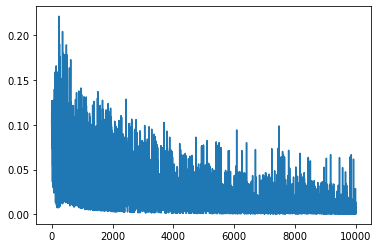

In [20]:
plt.plot(deltas)
plt.show()

In [21]:
# determine the policy from Q*
# find V* from Q*
policy = {}
V = {}
for s in grid.actions.keys():
  a, max_q = max_dict(Q[s])
  policy[s] = a
  V[s] = max_q

In [22]:
print("update counts:")
total = np.sum(list(update_counts.values()))
for k, v in update_counts.items():
  update_counts[k] = float(v) / total
print_values(update_counts, grid)

update counts:
---------------------------
 0.04| 0.05| 0.15| 0.00|
---------------------------
 0.03| 0.00| 0.15| 0.00|
---------------------------
 0.21| 0.19| 0.17| 0.02|


In [23]:
print("final values:")
print_values(V, grid)
print("final policy:")
print_policy(policy, grid)

final values:
---------------------------
-1.51|-0.37| 1.00| 0.00|
---------------------------
-2.61| 0.00|-0.36| 0.00|
---------------------------
-3.29|-2.42|-1.44|-1.00|
final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  R  |  R  |  U  |  U  |


## Q-learning (TD control problem, Off-Policy)
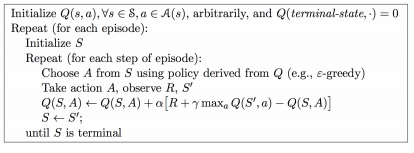

In [24]:
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

In [25]:
def random_action(a, eps=0.1):
  # epsilon-soft to ensure all states are visited
  p = np.random.random()
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [26]:
grid = negative_grid(step_cost=-0.1)

# print rewards
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


In [27]:
# no policy initialization, policy is derived from most recent Q like SARSA

# initialize Q(s,a)
Q = {}
states = grid.all_states()
for s in states:
  Q[s] = {}
  for a in ALL_POSSIBLE_ACTIONS:
    Q[s][a] = 0

# initial Q values for all states in grid
print(Q)

{(0, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (0, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (0, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (0, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}}


In [28]:
update_counts = {}
update_counts_sa = {}
for s in states:
  update_counts_sa[s] = {}
  for a in ALL_POSSIBLE_ACTIONS:
    update_counts_sa[s][a] = 1.0

In [29]:
# repeat until convergence
t = 1.0
deltas = []
for it in range(10000):
  if it % 100 == 0:
    t += 1e-2
  if it % 2000 == 0:
    print("iteration:", it)

  # instead of 'generating' an epsiode, we will PLAY
  # an episode within this loop
  s = (2, 0) # start state
  grid.set_state(s)

  # the first (s, r) tuple is the state we start in and 0
  # (since we don't get a reward) for simply starting the game
  # the last (s, r) tuple is the terminal state and the final reward
  # the value for the terminal state is by definition 0, so we don't
  # care about updating it.
  a, _ = max_dict(Q[s])
  biggest_change = 0
  while not grid.game_over():
    a = random_action(a, eps=0.5/t) # epsilon-greedy
    # random action also works, but slower since you can bump into walls
    # a = np.random.choice(ALL_POSSIBLE_ACTIONS)
    r = grid.move(a)
    s2 = grid.current_state()

    # adaptive learning rate
    alpha = ALPHA / update_counts_sa[s][a]
    update_counts_sa[s][a] += 0.005

    # we will update Q(s,a) AS we experience the episode
    old_qsa = Q[s][a]
    # the difference between SARSA and Q-Learning is with Q-Learning
    # we will use this max[a']{ Q(s',a')} in our update
    # even if we do not end up taking this action in the next step
    a2, max_q_s2a2 = max_dict(Q[s2])
    Q[s][a] = Q[s][a] + alpha*(r + GAMMA*max_q_s2a2 - Q[s][a])
    biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

    # we would like to know how often Q(s) has been updated too
    update_counts[s] = update_counts.get(s,0) + 1

    # next state becomes current state
    s = s2
    a = a2
   
  deltas.append(biggest_change)

iteration: 0
iteration: 2000
iteration: 4000
iteration: 6000
iteration: 8000


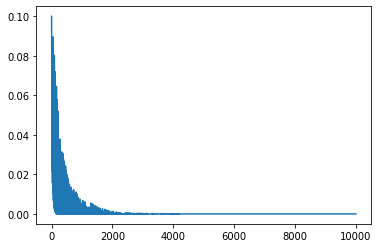

In [30]:
plt.plot(deltas)
plt.show()

In [31]:
# determine the policy from Q*
# find V* from Q*
policy = {}
V = {}
for s in grid.actions.keys():
  a, max_q = max_dict(Q[s])
  policy[s] = a
  V[s] = max_q

In [32]:
print("update counts:")
total = np.sum(list(update_counts.values()))
for k, v in update_counts.items():
  update_counts[k] = float(v) / total
print_values(update_counts, grid)

update counts:
---------------------------
 0.03| 0.04| 0.17| 0.00|
---------------------------
 0.02| 0.00| 0.16| 0.00|
---------------------------
 0.19| 0.19| 0.18| 0.02|


In [33]:
print("final values:")
print_values(V, grid)
print("final policy:")
print_policy(policy, grid)

final values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62| 0.46|
final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  R  |  R  |  U  |  L  |


## Function Approximation

## Deep Q-learning

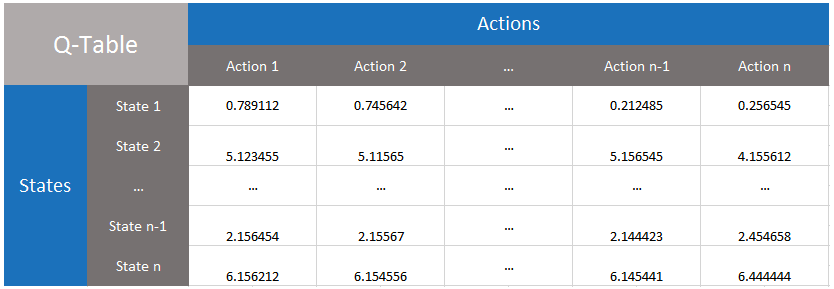

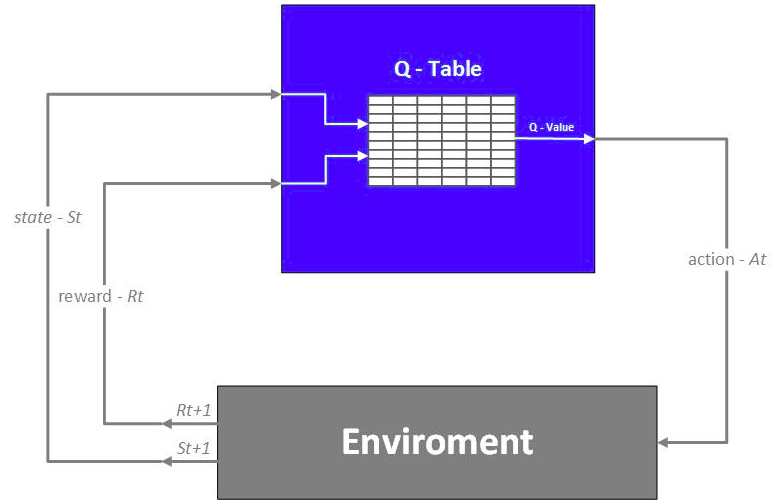

## Neural Network in Reinforcement Learning

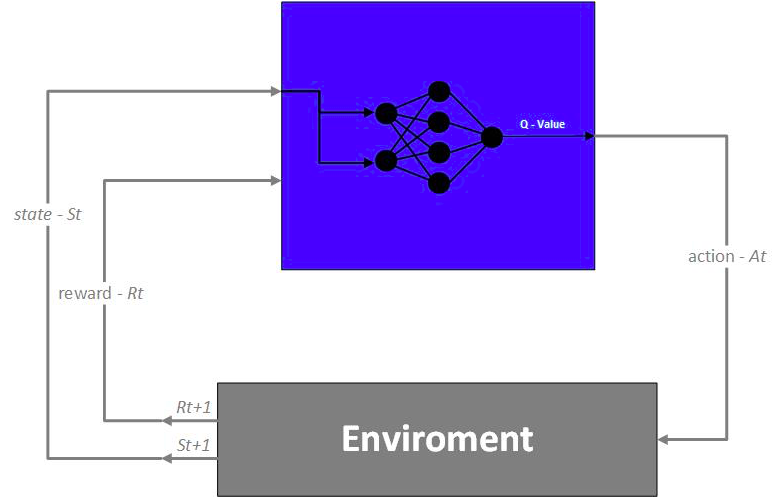

## Q-learning

In [34]:
import gym
env = gym.make("Taxi-v3").env
env.reset()
env.render()

print('Number of states: {}'.format(env.observation_space.n))
print('Number of actions: {}'.format(env.action_space.n))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Number of states: 500
Number of actions: 6


"There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions."

Action Space Discrete(6)
State Space Discrete(500)
<ul>
<li>The filled square represents the taxi, which is yellow without a passenger and green with a passenger</li>
<li>The pipe ("|") represents a wall which the taxi cannot cross.</li>
<li>R, G, Y, B are the possible pickup and destination locations.</li>
<li>The blue letter represents the current passenger pick-up location, and the purple letter is the current destination.</li>  
</ul>

### actions:
<ol>
<li>south</li>
<li>north</li>
<li>east</li>
<li>west</li>
<li>pickup</li>
<li>dropoff</li>
</ol>

In [35]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## Training the Agent

In [36]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [37]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 10001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 10000
Training finished.

CPU times: user 12.2 s, sys: 702 ms, total: 12.9 s
Wall time: 20.3 s


In [38]:
q_table[328]

array([-2.33394147, -2.27325256, -2.32357071, -2.32325921, -5.07832061,
       -4.49263628])

## illustration State

In [39]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


The max Q-value is "north" (-2.27325295), so it looks like Q-learning has effectively learned the best action to take in our illustration's state!

## Evaluating the agent
Let's evaluate the performance of our agent. We don't need to explore actions any further, so now the next action is always selected using the best Q-value:

In [40]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 10

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 10 episodes:
Average timesteps per episode: 12.7
Average penalties per episode: 0.0


## Task

Apply decline epsilon greedy action selection

In [41]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

t=0
for i in range(1, 10001):
    t=t+1
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon/t:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 10000
Training finished.

CPU times: user 6.73 s, sys: 394 ms, total: 7.12 s
Wall time: 17.9 s


## Mountain Car

<a href="https://gym.openai.com/envs/MountainCar-v0/"> Environment </a>

In [42]:
import numpy as np

import gym
from gym import wrappers

# initializations
number_states = 40 # number_of_states
max_iteration = 500 # max_iteration
initial_learning_rate = 1.0 # initial learning rate
min_learning_rate = 0.005   # minimum learning rate
max_step = 10000 # max_step

# parameters for q learning
epsilon = 0.05
gamma = 1.0




def observation_to_state(environment, observation):
    # map an observation to state
    environment_low = environment.observation_space.low
    environment_high = environment.observation_space.high
    environment_dx = (environment_high - environment_low) / number_states

    # observation[0]:position ;  observation[1]: volecity
    p = int((observation[0] - environment_low[0])/environment_dx[0])
    v = int((observation[1] - environment_low[1])/environment_dx[1])
    # p:position, v:volecity
    return p, v


def episode_simulation(environment, policy=None, render=False):
    observation= environment.reset()
    total_reward = 0
    step_count = 0
    for _ in range(max_step):
        if policy is None:
            action = environment.action_space.sample()
        else:
            p,v = observation_to_state(environment, observation)
            action = policy[p][v]
        if render:
            environment.render()
        # proceed environment for each step
        # get observation, reward and done after each step
        observation, reward, done, _ = environment.step(action)
        total_reward += gamma ** step_count * reward
        step_count += 1
        if done:
            break
    return total_reward


if __name__ == '__main__':
    # use gym environment: MountainCar-v0
    # https://github.com/openai/gym/wiki/MountainCar-v0
    environment_name = 'MountainCar-v0'
    environment = gym.make(environment_name)
    environment.seed(0)
    np.random.seed(0)
    
    # create qTable with zeros
    # 3 actions: 0:push_left, 1:no_push, 2:push_right
    q_table = np.zeros((number_states, number_states, 3))

    # training for maximum iteration episodes
    for i in range(max_iteration):
        observation = environment.reset()
        total_reward = 0
        # eta: learning rate is decreased at each step
        eta = max(min_learning_rate, initial_learning_rate * (0.85 ** (i//100)))
        # each episode is max_step long
        for j in range(max_step):
            p, v = observation_to_state(environment, observation)
            # select an action
            if np.random.uniform(0, 1) < epsilon:
                # get random action
                action = np.random.choice(environment.action_space.n)
            else:
                logits = q_table[p][v]
                # calculate the exponential of all elements in the input array.
                logits_exp = np.exp(logits)
                # calculate the probabilities
                probabilities = logits_exp / np.sum(logits_exp)
                # get random action
                action = np.random.choice(environment.action_space.n, p=probabilities)
                # get observation, reward and done after each step
                observation, reward, done, _ = environment.step(action)

            total_reward += reward
            # update q table
            # p:position, v:volecity
            p_, v_ = observation_to_state(environment, observation)
            # gamma: discount factor
            # Bellmann eq: Q(s,a)=reward + gamma* max(Q(s_,a_))  ::: Q_target = reward+gamma*max(Qs_prime)
            q_table[p][v][action] = q_table[p][v][action] + eta * (reward + gamma *  np.max(q_table[p_][v_]) - q_table[p][v][action])
            if done:
                break
        if i % 50 == 0:
            print('Iteration No: %d -- Total Reward : %d.' %(i+1, total_reward))

    solution_policy = np.argmax(q_table, axis=2)
    solution_policy_scores = [episode_simulation(environment, solution_policy, False) for _ in range(100)]
    print("Mean score : ", np.mean(solution_policy_scores))
# run with render=True for visualization
episode_simulation(environment, solution_policy, True)

Iteration No: 1 -- Total Reward : -210.
Iteration No: 51 -- Total Reward : -212.
Iteration No: 101 -- Total Reward : -208.


KeyboardInterrupt: 

## Deep Q-learning

In [43]:
import numpy as np
import random
from IPython.display import clear_output
from collections import deque
import progressbar



from keras import Model, Sequential
from keras.layers import Dense, Embedding, Reshape
from keras.optimizers import Adam

After this we can finally implement the agent. The Deep Q-Learning agent is implemented within the Agent class. Here is how that looks like:

In [44]:
class Agent:
    def __init__(self, enviroment, optimizer):
        
        # Initialize atributes
        self._state_size = enviroment.observation_space.n
        self._action_size = enviroment.action_space.n
        self._optimizer = optimizer
        
        self.expirience_replay = deque(maxlen=10)
        
        # Initialize discount and exploration rate
        self.gamma = 0.6
        self.epsilon = 0.1
        
        # Build networks
        self.q_network = self._build_compile_model()
        self.target_network = self._build_compile_model()
        self.alighn_target_model()

    def store(self, state, action, reward, next_state, terminated):
        self.expirience_replay.append((state, action, reward, next_state, terminated))
    
    def _build_compile_model(self):
        model = Sequential()
        model.add(Embedding(self._state_size, 10, input_length=1))
        model.add(Reshape((10,)))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(self._action_size, activation='linear'))
        
        model.compile(loss='mse', optimizer=self._optimizer)
        return model

    def alighn_target_model(self):
        self.target_network.set_weights(self.q_network.get_weights())
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return env.action_space.sample()
        
        q_values = self.q_network.predict(state)
        return np.argmax(q_values[0])

    def retrain(self, batch_size):
        minibatch = random.sample(self.expirience_replay, batch_size)
        
        for state, action, reward, next_state, terminated in minibatch:
            
            target = self.q_network.predict(state)
            
            if terminated:
                target[0][action] = reward
            else:
                t = self.target_network.predict(next_state)
                target[0][action] = reward + self.gamma * np.amax(t)
            
            self.q_network.fit(state, target, epochs=1, verbose=0)

In [45]:
optimizer = Adam(learning_rate=0.01)
agent = Agent(env, optimizer)

batch_size = 32
num_of_episodes = 100
timesteps_per_episode = 100
agent.q_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 10)             5000      
_________________________________________________________________
reshape (Reshape)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                550       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 8,406
Trainable params: 8,406
Non-trainable params: 0
_________________________________________________________________


In [46]:
for e in range(0, num_of_episodes):
    # Reset the enviroment
    state = env.reset()
    state = np.reshape(state, [1, 1])
    
    # Initialize variables
    reward = 0
    terminated = False
    
    bar = progressbar.ProgressBar(maxval=timesteps_per_episode/10, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for timestep in range(timesteps_per_episode):
        # Run Action
        action = agent.act(state)
        
        # Take action    
        next_state, reward, terminated, info = env.step(action) 
        next_state = np.reshape(next_state, [1, 1])
        agent.store(state, action, reward, next_state, terminated)
        
        state = next_state
        
        if terminated:
            agent.alighn_target_model()
            break
            
        if len(agent.expirience_replay) > batch_size:
            agent.retrain(batch_size)
        
        if timestep%10 == 0:
            bar.update(timestep/10 + 1)
    
    bar.finish()
    if (e + 1) % 10 == 0:
        print("**********************************")
        print("Episode: {}".format(e + 1))
        env.render()
        print("**********************************")

[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


**********************************
Episode: 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
**********************************


[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


**********************************
Episode: 20
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
**********************************


[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


**********************************
Episode: 30
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
**********************************


[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


**********************************
Episode: 40
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
**********************************


[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


**********************************
Episode: 50
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
**********************************


[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


**********************************
Episode: 60
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
**********************************


[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


**********************************
Episode: 70
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
**********************************


[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


**********************************
Episode: 80
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
**********************************


[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


**********************************
Episode: 90
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
**********************************


[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


**********************************
Episode: 100
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
**********************************


## Choosing a Deep RL library
<a href="https://medium.com/data-from-the-trenches/choosing-a-deep-reinforcement-learning-library-890fb0307092"> Some important libraries </a>

## Keras-rl

In [47]:
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory


ENV_NAME = 'MountainCar-v0'


# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
dqn.fit(env, nb_steps=1000, visualize=True, verbose=2)

# After training is done, we save the final weights.
dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                48        
_________________________________________________________________
activation (Activation)      (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_______________________________________

/Users/ramin/opt/anaconda3/lib/python3.7/site-packages/rl/memory.py:40: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


 200/1000: episode: 1, duration: 11.515s, episode steps: 200, steps per second:  17, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.115 [0.000, 2.000],  loss: 0.120084, mae: 0.675608, mean_q: -0.702846
 400/1000: episode: 2, duration: 5.739s, episode steps: 200, steps per second:  35, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.055 [0.000, 2.000],  loss: 0.006203, mae: 1.589347, mean_q: -2.334907
 600/1000: episode: 3, duration: 5.680s, episode steps: 200, steps per second:  35, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.080 [0.000, 2.000],  loss: 0.020309, mae: 2.661307, mean_q: -3.932230
 800/1000: episode: 4, duration: 5.887s, episode steps: 200, steps per second:  34, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.995 [0.000, 2.000],  loss: 0.032381, mae: 3.771887, mean_q: -5.591359
 1000/1000: episode: 5, duration: 4.984s, episode steps: 200, steps

In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install TensorFlow

In [ ]:
pip install tensorflow --upgrade

In [ ]:
pip tensorflow --version 